
# Exercise 1

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
Lambda = [
    [0, 2/5, 1/5, 0, 0],
    [0, 0, 3/4, 1/4, 0],
    [1/2, 0, 0, 1/2, 0],
    [0, 0, 1/3, 0, 2/3],
    [0, 1/3, 0, 1/3, 0]
]


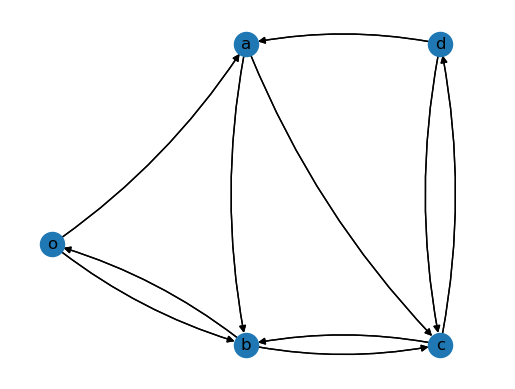

In [3]:
%matplotlib inline


G = nx.DiGraph()
G.add_edges_from([('o','a'),('o','b'),('b','o'),('a','b'),('b','c'),('c','b'),('a','c'),('d','c'),('d','a'),('c','d'),('d','c')])

pos = {'o': [0,2], 'a': [2,6], 'b': [2,0], 'c': [4,0], 'd': [4,6] }

indices = {n:i  for i, n in enumerate(G.nodes) }
nx.draw_networkx_edges(
    G, pos,
    connectionstyle="arc3,rad=0.1"  # <-- THIS IS IT
)
nx.draw(G,pos, with_labels = True,connectionstyle="arc3,rad=0.1")

network in which particles move according to the transition rate matrix 
$$
\Lambda = 
\begin{pmatrix}
0 & 2/5 & 1/5 & 0 & 0\\
0 & 0 & 3/4 & 1/4 & 0\\
1/2 & 0 & 0 & 1/2 & 0\\
0 & 0 & 1/3 & 0 & 2/3\\
0 & 1/3 & 0 & 1/3 & 0\\
\end{pmatrix}
\begin{matrix}
o \\ a \\ b \\ c \\ d
\end{matrix}
$$

**a)** What is, according to the simulations, the average time it takes a particle that starts in node a to leave the node and then return to it?

A unique global Poisson clock  it's  defined, with rate $\omega^* = \max_i(\omega_i)$   where $\omega_i= \sum_j \Lambda_{ij}$ and $\Lambda$ represents the transition rate matrix. After each Poisson clock ticks the particle jumps to a neighbor j with probability  $Q_{ij} = \frac{\Lambda_{ij}}{\omega_{*}}, \; i \neq j$ or remain in the same node with probability  $Q_{ii} = 1 - \sum_{i \neq j} Q_{ij}$. 

The time $t_{next}$ between two ticks of the Poisson clock is calculate in the follow way: $t_{next}=\frac{-ln(u)}{\omega^*}$ Where u is a uniformly distributed random variable U(0, 1).

Simulation of 100.000 experiments for the average return time calculation

In [4]:
w = np.sum(Lambda, axis=1)
w_star = np.max(w)
# compute the off-diagonal part of Q
Q = Lambda/w_star 
# add the diagonal part
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))

# compute dominant eigenvector
values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

nstates = len(pi_bar)

pi_bar= [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]


In [5]:
# 1st approach: global clock with rate w_star and matrix Q
def trans_time(Q, pos_init, pos_fin):

    n_states = Q.shape[0]
    pos = np.zeros(1, dtype=int)
    pos[0] = pos_init
    t_next = -np.log(np.random.rand())/w_star
    transition_times = np.zeros(1,dtype=int)
    transition_times = np.append(transition_times, transition_times[-1] + t_next)
    pos = np.append(pos, np.random.choice(nstates, p=Q[pos[-1],:]))

    while pos_fin != pos[-1]:
            
        pos = np.append(pos,np.random.choice(n_states,p=Q[pos[-1],:]))
        transition_times = np.append(transition_times,transition_times[-1]+t_next)
        t_next = -np.log(np.random.rand())/w_star
            
    return transition_times[-1]

   

The average time it takes "a" particle that starts in node
a to leave the node and then return to it is computed as follow

In [6]:
n_tests = int(1e5)

return_times = []

for i in range(n_tests):
    return_times.append(trans_time(Q, 1, 1))
print(np.mean(return_times))

6.728100752832715


b) How does the result in point "a" compare to the theoretical return-time $E_{a}[T^{+}_a]$? (Include a description of how this is computed.)



In [48]:

1/pi_bar[1]*w[1]

6.750000000000004

c) What is, according to the simulations, the average time it takes to move from node o to node
d?

Simulation of 100.000 experiments for the average transition time from node o to node d


In [49]:
n_tests = int(1e5)

hitting_time = []

for i in range(n_tests):
    hitting_time.append(trans_time(Q, 0, 4))

In [50]:
print(np.mean(hitting_time))

8.832954680718414


d) How does the result in c) compare to the theoretical hitting-time $E_{o}[T_{d}]$? (Describe also how
this is computed.)



$$
\mathbb{E}_i[T_S] = \frac{1}{\omega_i} + \sum_{j} P_{ij} \mathbb{E}_j[T_S] \quad\text{for }i \notin S 
$$

where $S \subseteq V$ and $V=\{d\}$ ${\mathbb{E}}_o[T_S]$ for all the nodes $R =V \backslash S$  can be calculated by solving the system:
$$\tau = \frac{1}{\omega} + P_{|R x R} \tau $$

In [24]:
D = np.diag(w)
P = np.linalg.inv(D)@Lambda

In [8]:
def hitting_time_function(o, d):

    S = [indices[d]] # refer to nodes 'o'
    R = [node for node in range(len(G.nodes)) if node not in S]

    map = {n:i for i,n in enumerate(R)}

    D = np.diag(w)
    P = np.linalg.inv(D) @ Lambda
    # Restrict P to R x R to obtain hat(P)
    hatP = P[np.ix_(R, R)]

    t = np.linalg.inv((np.identity(hatP.shape[0]) - hatP)) @ (1/np.array(w[R]))
    print(f'{t[map[indices[o]]]:.2f}')

In [13]:
hitting_time_function('o', 'd')

8.79


e)Interpret the matrix Λ as the weight matrix of a graph $G = (V, E, Λ)$, and simulate the French-DeGroot dynamics on G with an arbitrary initial condition x(0). Does the dynamics converge
to a consensus state for every initial condition x(0)? Motivate your answer.


Regardless of initial conditions a consensus status is reached immediately after few iterations,  this is because the graph is strongly connected and aperiodic.

In [34]:
values,vectors = np.linalg.eig(P.T)
index = np.argmax(values.real)
pi = vectors[:,index].real
pi = pi/np.sum(pi)

In [35]:
pi

array([0.13043478, 0.17391304, 0.26086957, 0.26086957, 0.17391304])

$\pi' x(t)$ is the motion invariant, so $\pi'\overline{x}$ is equal to $\pi'x(0)$

The consensus value reached is equal to $$\alpha = \sum_{k}{\pi_k x(0)_k}$$ that is the weighted average of the nodes' initial opinions.

In [39]:
x_0 = np.random.uniform(0,1, len(pi))
cons = x_0@pi
cons

0.41702680753171767

# RIVEDI

In [30]:
def french_dg(P, x0, pi, n_iter):
    alpha = pi@x0
    x_bar_teoretical = np.ones(len(pi))*alpha
    x_bar = x0
    for n in range(n_iter):
        x_bar = P @ x_bar
    return x_bar, x_bar_teoretical

    

In [31]:
x0 = np.random.uniform(0,1,len(pi))
n_iter = int(1e4)
x_bar, x_bar_theoretical = french_dg(P, x0, pi, n_iter)

In [32]:
print(f'x_bar: {x_bar}\nx_bar_x_bar_theoretical {x_bar_theoretical}' )

x_bar: [0.43803497 0.43803497 0.43803497 0.43803497 0.43803497]
x_bar_x_bar_theoretical [0.43803497 0.43803497 0.43803497 0.43803497 0.43803497]


f) Assume that the initial state of the dynamics for each node i ∈ V is given by xi(0) = $ξ_{i}$, where
{$ξ_{i}$}$_{i∈V}$ are i.i.d random variables with variance σ
2. Compute the variance of the consensus
value, and compare your results with numerical simulations.

-------------------------------------------------------------

In [9]:
partenza = 0
n_part=100
pos = [[partenza] for i in range(n_part)]
transition_times = [[0] for i in range(n_part)]

t_next=[]

In [10]:
n_states = len(pi_bar)

In [11]:
pos_arrays = [[1] for i in range(100)]
transition_times = [[0] for i in range(100)]

In [12]:
degrees = np.sum(np.array(Lambda),axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ np.array(Lambda)

#print(P)
x0 = np.random.uniform(0,1,len(pi))
res=np.array([1, 0, 0, 0, 0])
for n in range(50):
    x = P @ x0
print("x(50):", x, "\n")

for n in range(100):
    x = P @ x
print("x(100):", x, "\n")

for n in range(200):
    #print(x)
    x = P @ x
    res =np.vstack((res,x.copy()))
print("x(200):", x, "\n")

NameError: name 'pi' is not defined

## EX 2

In [58]:
def return_time_particles(w,init,pos_arrays,transition_times, nstates, n_particles, Q):
    pos=init
    pos_arrays = [[init] for i in range(n_particles)]
    transition_times = [[0] for i in range(n_particles)]
    for i in range(n_particles):#valori iniziali
        t_next = -np.log(np.random.rand())/w[pos]
        pos = np.random.choice(nstates, p=Q[pos,:])
        pos_arrays[i].append(pos)
        transition_times[i].append(transition_times[i][-1]+t_next)

    while [i[-1] for i in pos_arrays] != [i[0] for i in pos_arrays]:

        for i in range(n_particles):
            t_next = -np.log(np.random.rand())/w[pos]
            pos = np.random.choice(nstates, p=Q[pos,:])
            if pos_arrays[i][-1] != pos_arrays[i][0]:
                pos_arrays[i].append(pos)
                transition_times[i].append(transition_times[i][-1]+t_next)
    return transition_times, pos

In [59]:
n_particles = 100
t, p = return_time_particles(w,1,pos_arrays,transition_times, nstates, n_particles, Q)

In [60]:
t

[[0,
  1.0425328623712542,
  3.1954696249829375,
  3.8713391060507876,
  4.517580749747049],
 [0, 2.115100416170556, 2.2099652805271015, 4.865233068106358],
 [0,
  3.1550856957534994,
  3.597498787735035,
  4.7379735281096025,
  5.4206027979379785,
  6.190531255285241,
  6.7655826789902465,
  7.1375463582816945,
  7.918718798628313,
  8.433490170278215,
  8.508443250195572,
  9.305367647911435,
  9.32428950987606,
  9.403445932395126,
  9.650674649459036,
  11.822377582186924,
  12.514920705409383,
  13.143348455878378,
  15.149407401880524,
  16.003206233308084,
  16.59830844566223,
  17.903132973260284,
  18.38778611443834,
  18.69651442522049,
  18.74877018768619],
 [0, 4.313210018809271],
 [0, 0.06717250868684872, 0.37700205686659666, 3.1150298014686495],
 [0,
  1.2757543420713917,
  2.5283402904650547,
  2.832878357831117,
  3.6181843277464,
  3.975359925209073,
  6.3303891375259145,
  6.486497741784319,
  7.0692587100902085,
  7.313661941476993,
  11.607910546954134,
  12.9926194

In [61]:
np.mean([i[-1] for i in t])

8.281499623113696

## ex2 punto 2


If 100 particles start in node o, and the system is simulated for 60 time units, what is
the average number of particles in the different nodes at the end of the simulation?

In [62]:
def time_node(w,init,maxpart,tmax, nstates, Q):
    particelle_node=[0 for i in range(nstates)]#setto a zero il numero di particelle per ogni nodo
    particelle_node[init]=maxpart#le metto tutte nel nodo o
    part_time=[]
    part_time.append(particelle_node[:])#faccio un vettore per segnare particelle al tempo
    time_vector=[]#creo vettore dei tempi per poterlo rappresentare
    transition_times=[0]
    global_time=0
    global_time += -np.log(np.random.rand())/(w*maxpart)
    time_vector.append(global_time)
  
   
    

    

    while global_time < tmax:
        time_vector.append(global_time)
        t_next = -np.log(np.random.rand())/(w*maxpart)
            
        n_from = np.random.choice(range(nstates), p=np.array(particelle_node)/maxpart) 
        n_to = np.random.choice(range(nstates), p=Q[n_from,:])
        global_time+=t_next  
        particelle_node[n_from]-=1
        particelle_node[n_to]+=1
       
        part_time.append(particelle_node[:])
   
    return part_time, time_vector,

In [63]:
n_particles = 100

p,t= time_node(w_star,0,100,60,nstates, Q)

In [64]:
p

[[100, 0, 0, 0, 0],
 [100, 0, 0, 0, 0],
 [99, 1, 0, 0, 0],
 [99, 1, 0, 0, 0],
 [98, 1, 1, 0, 0],
 [97, 2, 1, 0, 0],
 [97, 2, 1, 0, 0],
 [96, 3, 1, 0, 0],
 [95, 4, 1, 0, 0],
 [94, 4, 2, 0, 0],
 [93, 5, 2, 0, 0],
 [93, 5, 2, 0, 0],
 [93, 5, 2, 0, 0],
 [93, 5, 2, 0, 0],
 [93, 5, 2, 0, 0],
 [92, 5, 3, 0, 0],
 [92, 5, 3, 0, 0],
 [91, 5, 4, 0, 0],
 [91, 5, 4, 0, 0],
 [90, 6, 4, 0, 0],
 [90, 6, 4, 0, 0],
 [90, 6, 4, 0, 0],
 [89, 6, 5, 0, 0],
 [89, 6, 5, 0, 0],
 [89, 6, 5, 0, 0],
 [89, 6, 5, 0, 0],
 [88, 7, 5, 0, 0],
 [88, 7, 5, 0, 0],
 [87, 8, 5, 0, 0],
 [86, 9, 5, 0, 0],
 [85, 9, 6, 0, 0],
 [85, 8, 7, 0, 0],
 [84, 9, 7, 0, 0],
 [84, 9, 7, 0, 0],
 [84, 9, 7, 0, 0],
 [84, 9, 7, 0, 0],
 [84, 9, 7, 0, 0],
 [84, 9, 6, 1, 0],
 [84, 9, 6, 1, 0],
 [83, 9, 7, 1, 0],
 [82, 10, 7, 1, 0],
 [81, 11, 7, 1, 0],
 [80, 12, 7, 1, 0],
 [81, 12, 6, 1, 0],
 [81, 12, 6, 1, 0],
 [80, 13, 6, 1, 0],
 [80, 12, 7, 1, 0],
 [81, 12, 6, 1, 0],
 [81, 12, 5, 2, 0],
 [80, 12, 6, 2, 0],
 [80, 11, 7, 2, 0],
 [79, 12, 7, 2, 0]

In [65]:
n_step = 10
n_particles = 100
p,t = time_node(w_star,0,100,1000,nstates, Q)


In [66]:
vectp=[]
times=[]
time=60
times.append(time)
while(time<1000):
    p,_ = time_node(w_star,0,100,time,nstates, Q)
    vectp.append(np.array(p).mean(0)/len(p)*1000)
    time+=300
    times.append(time)
    

In [67]:
vectp

[array([3.30982433, 2.44307997, 3.74026057, 3.49935293, 3.34468201]),
 array([0.5176499 , 0.41712699, 0.62032378, 0.60733683, 0.60427343]),
 array([0.29022022, 0.22543429, 0.33918631, 0.33455496, 0.3366927 ]),
 array([0.19424344, 0.15599351, 0.23149616, 0.231097  , 0.23078246])]

In [25]:
diff=pi_bar-vectp

In [68]:
diff

array([[-3.47184558, -2.10628889, -3.52338724, -3.20424264, -3.02343225],
       [-0.36051824, -0.25466817, -0.3989654 , -0.37735772, -0.3856511 ],
       [-0.10552388, -0.07258928, -0.11472625, -0.10797656, -0.11566822],
       [-0.00878692, -0.00817944, -0.01128809, -0.0079555 , -0.00777305]])

In [69]:
pi_bar

array([0.18518519, 0.14814815, 0.22222222, 0.22222222, 0.22222222])

In [70]:
np.array(diff).mean(1)

array([-3.06583932, -0.35543213, -0.10329684, -0.0087966 ])

In [71]:
np.array(vectp).shape

(4, 5)

In [87]:
def pi_plot(t, v, labels): 
 fig = plt.figure(dpi=200, figsize=(9,3)) 
 ax  = fig.add_subplot(111) 
 for l,i in zip(labels, range(v.shape[0])): 
  ax.plot(np.arange(0, 5), v[i,:].T, label=l, linewidth=0.8) 
 ax.plot(np.arange(0, 5), t, label='invariant distribution', linewidth=0.8) 
 ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5)) 
 ax.set_xlabel('index') 
 ax.set_ylabel('value') 
 
 plt.savefig('C:/Users/Chiara/Desktop/network/fig/grafico2.svg')
 return fig

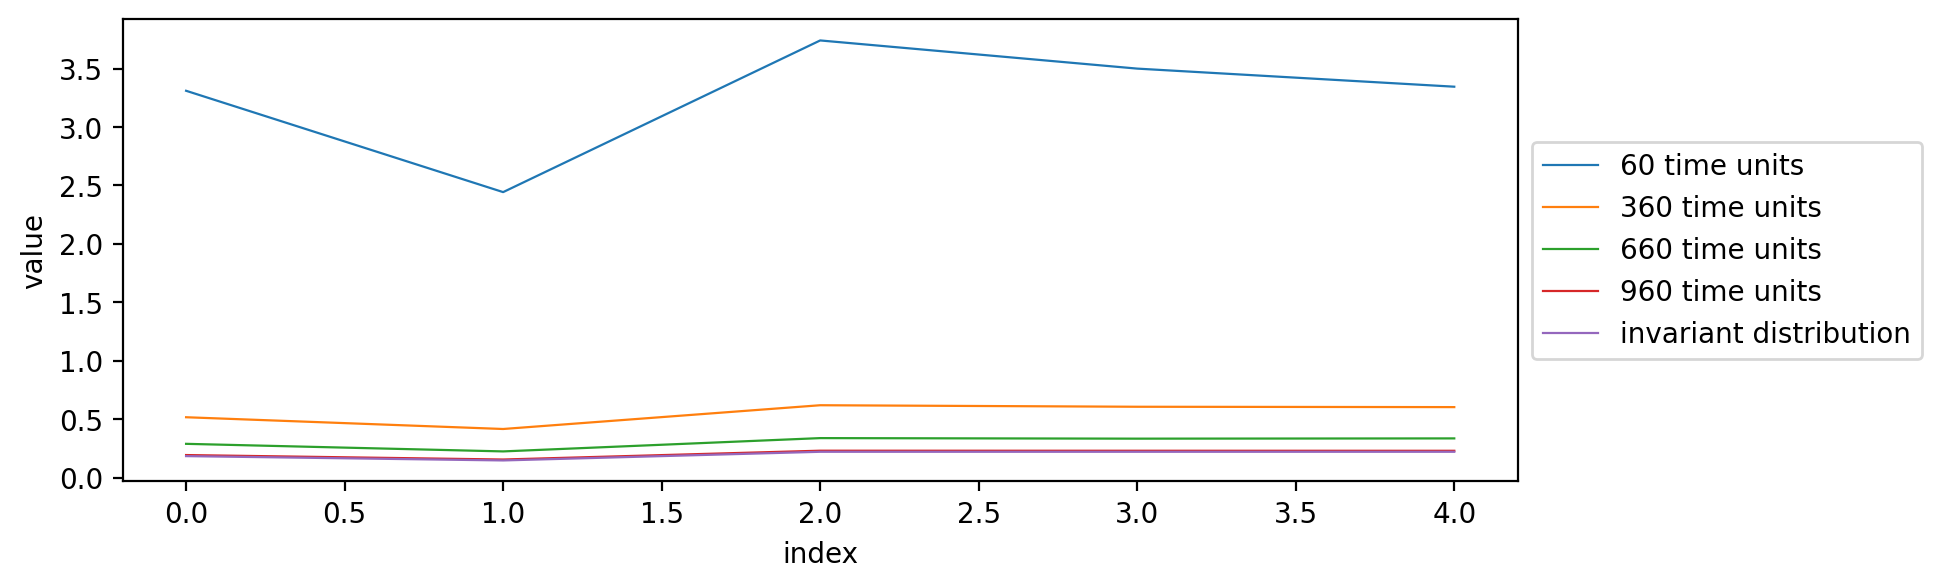

In [88]:
labels=['60 time units','360 time units','660 time units' ,'960 time units']
f=pi_plot(pi_bar, np.array(vectp),labels)


In [ ]:
p

[[100, 0, 0, 0, 0],
 [99, 1, 0, 0, 0],
 [98, 1, 1, 0, 0],
 [98, 1, 1, 0, 0],
 [98, 1, 1, 0, 0],
 [97, 1, 2, 0, 0],
 [96, 2, 2, 0, 0],
 [95, 3, 2, 0, 0],
 [94, 4, 2, 0, 0],
 [93, 4, 3, 0, 0],
 [93, 4, 3, 0, 0],
 [93, 4, 3, 0, 0],
 [92, 5, 3, 0, 0],
 [92, 4, 4, 0, 0],
 [92, 3, 4, 1, 0],
 [92, 3, 4, 1, 0],
 [92, 3, 4, 1, 0],
 [92, 3, 4, 1, 0],
 [91, 3, 5, 1, 0],
 [90, 4, 5, 1, 0],
 [89, 5, 5, 1, 0],
 [88, 6, 5, 1, 0],
 [87, 7, 5, 1, 0],
 [87, 7, 5, 1, 0],
 [86, 8, 5, 1, 0],
 [85, 9, 5, 1, 0],
 [85, 9, 5, 1, 0],
 [84, 10, 5, 1, 0],
 [84, 9, 5, 2, 0],
 [84, 9, 5, 2, 0],
 [83, 9, 6, 2, 0],
 [83, 8, 7, 2, 0],
 [83, 7, 8, 2, 0],
 [82, 8, 8, 2, 0],
 [82, 8, 8, 2, 0],
 [81, 9, 8, 2, 0],
 [81, 8, 9, 2, 0],
 [81, 7, 10, 2, 0],
 [81, 7, 10, 2, 0],
 [81, 6, 11, 2, 0],
 [82, 6, 10, 2, 0],
 [81, 7, 10, 2, 0],
 [80, 8, 10, 2, 0],
 [79, 9, 10, 2, 0],
 [80, 9, 9, 2, 0],
 [79, 10, 9, 2, 0],
 [79, 10, 9, 2, 0],
 [79, 10, 9, 2, 0],
 [78, 11, 9, 2, 0],
 [77, 12, 9, 2, 0],
 [77, 12, 9, 2, 0],
 [78, 12, 8, 2, 

In [ ]:
np.array(p).mean(0)

array([18.87662913, 14.91008157, 22.44906081, 22.16150104, 21.60272745])

In [ ]:
def time_plot(t, v, labels): 
 fig = plt.figure(dpi=200, figsize=(9,3)) 
 ax  = fig.add_subplot(111) 
 ax.set_position([0.075,0.15,0.85,0.8]) 
 for l,i in zip(labels, range(v.shape[0])): 
  ax.plot(np.array(t), v[i,:].T, label=l, linewidth=0.8) 
 ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5)) 
 ax.set_xlabel('time') 
 ax.set_ylabel('number of particles') 
 #plt.figure(dpi=120)

 #plt.savefig('C:/Users/Chiara/Desktop/network/fig/grafico1.png')
 return fig

In [ ]:
pi_bar

array([0.18518519, 0.14814815, 0.22222222, 0.22222222, 0.22222222])

# ex 3


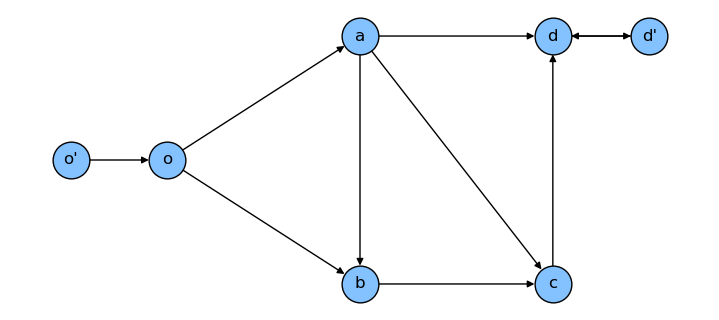

In [ ]:
G3 = nx.DiGraph() 
 
G3.add_nodes_from(["o'", "o", "a", "b", "c", "d", "d'"]) 
G3.add_edges_from([("o'", "o"), ("o", "a"), ("o", "b"), ("a", "b"), ("a", "c"), ("a", "d"), ("b", "c"), ("c", "d"), ("d", "d'"), ("d'", "d")]) 
# set positions of nodes to have the same disposition of the given figure 
pos3 = {"o'":[0,1], "o":[1,1], "a":[3,2], "b":[3,0], "c":[5,0], "d":[5,2], "d'":[6,2]} 
 
fig = plt.figure(1, figsize=(7, 3)) 
 
options = {"edgecolors": "black", "node_size": 700} 
nx.draw(G3, pos3, with_labels=True, node_color="#83C1FF", **options) 
plt.savefig("Graph_ex3.svg")

In [ ]:
Lambda_open = np.array([[1,0,0,0,0,0,0],
                        [0,0, 3/4, 3/8, 0, 0, 0],  
                        [0, 0, 0, 1/4, 1/4, 2/4, 0],  
                        [0, 0, 0, 0, 1, 0, 0],  
                        [0, 0, 0, 0, 0, 1, 0],  
                        [0, 0, 0, 0, 0, 0, 2],  
                        [0, 0, 0, 0, 0, 1, 0]])

In [ ]:
import random

In [ ]:
w = np.sum(Lambda, axis=1)
w_star = np.max(w)
# compute the off-diagonal part of Q
Q = Lambda/w_star 
# add the diagonal part
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))

# compute dominant eigenvector
values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

nstates = len(pi_bar)

pi_bar= [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]


In [ ]:
def choice(listato): 
  times = np.array([random.expovariate(rate) if rate != 0 else 10000 for rate in listato])
  index = np.argmin(times)
  t=times[index]
  return index, t

In [ ]:
def time_node3(init,maxpart,tmax, nstates, Q):
    particelle_node=[0 for i in range(nstates)]#setto a zero il numero di particelle per ogni nodo
    particelle_node[init]=maxpart#le metto tutte nel nodo o
    print(particelle_node)
    i, time = choice(particelle_node)

    part_time=[]
    part_time.append(particelle_node[:])#faccio un vettore per segnare particelle al tempo
    time_vector=[]#creo vettore dei tempi per poterlo rappresentare

    time_vector.append(time)
    
    

    while time < tmax:
        time_vector.append(time)
        n_from=i
        # t_next = -np.log(np.random.rand())/(w*maxpart)
            
        n_from = np.random.choice(range(nstates), p=np.array(particelle_node)/maxpart) 
        n_to = np.random.choice(range(nstates), p=Q[n_from,:])
        particelle_node[n_from]-=1
        particelle_node[n_to]+=1
       
        i, time = choice(particelle_node)
        time+=time  
        
        part_time.append(particelle_node[:])
   
    return part_time, time_vector

In [ ]:
n_particles = 100
p,t = time_node3(0,10000,60,nstates, Q)

[10000, 0, 0, 0, 0]


KeyboardInterrupt: 

In [ ]:
def time_plot(t, v, labels): 
 fig = plt.figure(dpi=200, figsize=(9,3)) 
 ax  = fig.add_subplot(111) 
 ax.set_position([0.075,0.15,0.85,0.8]) 
 for l,i in zip(labels, range(v.shape[0])):
    
  ax.plot(np.array(t), v[i,:].T, label=l, linewidth=0.8) 
 ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5)) 
 ax.set_xlabel('time') 
 ax.set_ylabel('number of particles') 
 #plt.savefig(f'fig/{img}.png') 
 return fig

In [ ]:
labels=['nullo','o','a','b','c','d','nullo2' ]

f=time_plot(t,np.array(p).T,labels)